# Setup

In [1]:
!nvidia-smi

Mon Feb 14 01:45:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%shell

rm -rf object-detection | true
git clone -b model/R-CNN  https://github.com/Howard-O-Neil/object-detection.git

Cloning into 'object-detection'...
remote: Enumerating objects: 454, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 454 (delta 282), reused 302 (delta 134), pack-reused 0
Receiving objects: 100% (454/454), 1.32 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [5]:
%%shell

touch train.log
ls -a
pwd

.  ..  .config	drive  object-detection  sample_data  train.log
/content


# Training

In [6]:
import os

MODEL_ID = 1
TRANSFER_ID = 1

os.environ["dataset"] = "/content/drive/My Drive/dataset/PASCAL_VOC_2012/VOCdevkit/VOC2012"
os.environ["dataset2"] = "/content/drive/My Drive/dataset/PASCAL_VOC_2012/VOCdevkit/BBox pairs"
os.environ["model_path"] = f"/content/drive/My Drive/model/R_CNN/model{MODEL_ID}"
os.environ["transfer_path"] = f"/content/drive/My Drive/model/R_CNN/transfer{TRANSFER_ID}"
os.environ["log_path"] = "/content/train.log"

In [7]:
import sys
sys.path.insert(0, "/content/object-detection/src")

In [8]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import mylib.io_utils.VOC_2012 as io_voc_2012

import model.model_imagenet.bbox_predict as bbp
import model.model_imagenet.img_cnn_core as icnn

x_DF = pd.read_csv(f"""{os.getenv("dataset2")}/bbox_X_MERGED.csv""")
y_DF = pd.read_csv(f"""{os.getenv("dataset2")}/bbox_Y_MERGED.csv""")
imgs_DF = pd.read_csv(f"""{os.getenv("dataset2")}/image_ID_MERGED.csv""")

# remove pandas column np.array
x_DF = np.array(x_DF.values.tolist()).astype(np.float32)[:, 1:]
y_DF = np.array(y_DF.values.tolist()).astype(np.float32)[:, 1:]
imgs_DF = np.array(imgs_DF.values.tolist())[:, 1]

trainval_list = np.array(io_voc_2012.get_imgs_dataset("trainval"))

split_index = int(trainval_list.shape[0] * 0.9)
train_list = trainval_list[0:split_index]
val_list = trainval_list[split_index:trainval_list.shape[0]]

In [9]:
os.environ["train_batch_size"] = "32"
os.environ["lambda"] = "0.00005"
os.environ["learning_rate"] = "0.000000001"
os.environ["epoch"] = "1"

In [10]:
image_cnn_core = icnn.CNN_core().get_model()

bbox_model = bbp.Bbox_predict()
bbox_model.assign_cnn_model(image_cnn_core)
bbox_model.assign_img_list_train(train_list)
bbox_model.assign_img_list_validation(val_list)
bbox_model.assign_bbox_dataset(x_DF, y_DF, imgs_DF)

553476096/553467096 [==============================] - 16s 0us/step


In [10]:
bbox_model.train_loop(transfer=True)

Streaming output truncated to the last 5000 lines.
2022-02-13 20:31:51,304 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 6.846399307250977
2022-02-13 20:31:51,394 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 6.342710494995117
2022-02-13 20:31:51,476 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 4.755324363708496
2022-02-13 20:31:52,559 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 5.861479759216309
2022-02-13 20:31:52,648 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 5.636624336242676
2022-02-13 20:31:52,701 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 3.6857528686523438
2022-02-13 20:31:53,360 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 8.613078117370605
2022-02-13 20:31:53,410 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 3.7120096683502197
2022-02-13 20:31:55,951 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 7.318907737731934
2022-02-13 20:31:56,039 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 7.3159284591674805
2022-02-13 20:31:56,128 - INFO - [TRAINING] EPOCH_ID: 0, BATCH LOSS: 7.34731

In [11]:
bbox_model.save_model()

# Demo

In [11]:
bbox_model.load_model()

In [12]:
import mylib.img_utils as imu
import cv2
import PIL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(281, 500, 3)


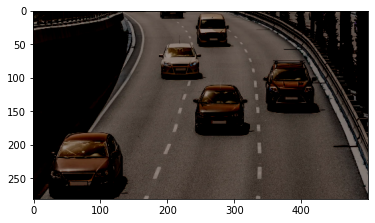

In [29]:
img_path = f"""/content/drive/My Drive/Image/car_6.webp"""

img_tensor = tf.cast(
    tf.convert_to_tensor(np.asarray(PIL.Image.open(img_path))),
    tf.dtypes.float32,
)
original_img = tf.image.resize(
    img_tensor, [500, 500], method="bilinear", preserve_aspect_ratio=True  
).numpy()

scale_img = imu.imagenet_load([img_path])[0]

print(scale_img.shape)

plt.imshow(scale_img / 255.)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 36 173  98  75]
 [438  81  48  82]
 [ 38 179  84  36]
 ...
 [241   0 168  72]
 [342  23  96 137]
 [411  12  89 257]]


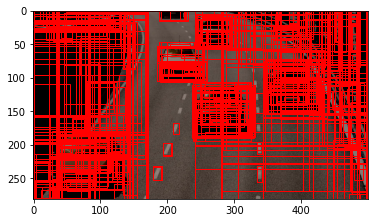

In [30]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(scale_img)
ss.switchToSelectiveSearchFast() # reduce number of boxes

boxes = ss.process()

print(boxes)

fig, ax = plt.subplots(1)

plt.imshow(scale_img / 255.)
for i, rect in enumerate(boxes):
    r = mpatches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor="none")
    ax.add_patch(r)

plt.show()

In [31]:
import model.model_imagenet.VGG_16 as vgg

vgg_16 = vgg.Pretrain_VGG16()
scores = vgg_16.predict_scores(scale_img, boxes)

In [32]:
predict_boxes = bbox_model.predict_bboxs(scale_img, boxes)

In [43]:
compatible_boxes = np.copy(predict_boxes)
compatible_boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
compatible_boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

selected_indices = tf.image.non_max_suppression(
    compatible_boxes, scores, max_output_size=100, iou_threshold=0.4, score_threshold=0.6)
gather = tf.gather(compatible_boxes, selected_indices)

print(gather.numpy())

[[  0  -8 129  50]
 [348  69 406 110]
 [ 19 172 140 281]
 [240   2 289  54]
 [400 101 423 138]
 [360 104 405 116]
 [249 137 307 152]
 [342  92 368 139]
 [270   0 316   5]
 [182  43 259 102]
 [251   2 339  21]
 [232 104 327 186]]


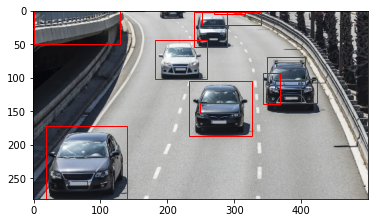

In [44]:
gather_boxes = gather.numpy()
NMS_boxes = np.copy(gather_boxes)
NMS_boxes[:, 2] = gather_boxes[:, 2] - gather_boxes[:, 0]
NMS_boxes[:, 3] = gather_boxes[:, 3] - gather_boxes[:, 1]


fig, ax = plt.subplots(1)
plt.imshow(original_img / 255.)

for i, rect in enumerate(NMS_boxes):
    r = mpatches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=1, edgecolor='r', facecolor="none")
    ax.add_patch(r)

plt.show()
